# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [8]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

## 2. Load Simulated Data

In [9]:
# File path
npz_file_path = os.path.join("./results", "simulated_data_fine_grid.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print("Successfully loaded arrays and config from simulated_data_fine_grid.npz.")

Successfully loaded arrays and config from simulated_data_fine_grid.npz.


In [10]:
# Reduce Stepsize px
step_size_px = 20
points_per_wavelength = 4

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-13 19:30:31,714 - INFO - === Scan Summary ===
2025-12-13 19:30:31,715 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-13 19:30:31,717 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-13 19:30:31,719 - INFO -   Sample Pixels:          3001 px
2025-12-13 19:30:31,722 - INFO -   Step size:              20 px
2025-12-13 19:30:31,723 - INFO -   Number of scan points:  60
2025-12-13 19:30:31,724 - INFO -   Steps in z:             251
2025-12-13 19:30:31,725 - INFO -   Probe diameter:         1.000e-05 m
2025-12-13 19:30:31,727 - INFO -   Probe Pixels:           200 px
2025-12-13 19:30:31,728 - INFO -   Max Overlap:            9.000e-06 m
2025-12-13 19:30:31,730 - INFO -   Percentage Overlap:     90.00%



Reduce Stepsize px: 100 -> 20
Points per wavelength: 32 -> 4


## 3. Reduce Data Dimensionality

Original exit waves shape: (60, 15001)
Coarse exit waves shape: (60, 3001)


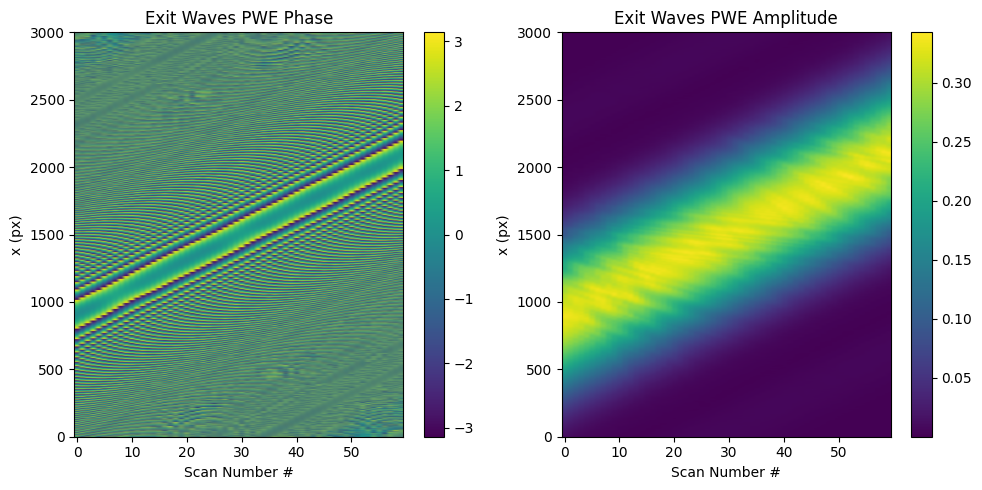

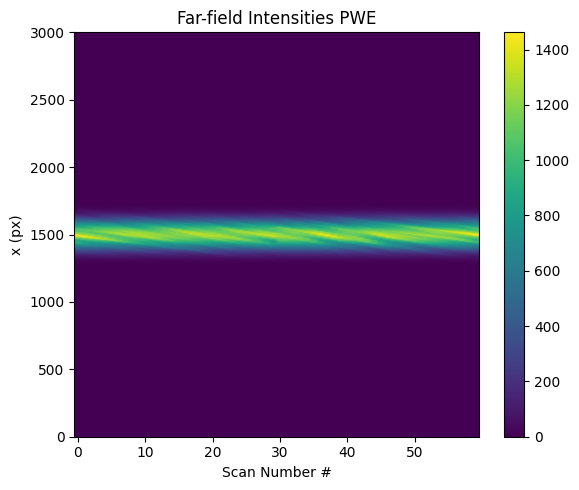

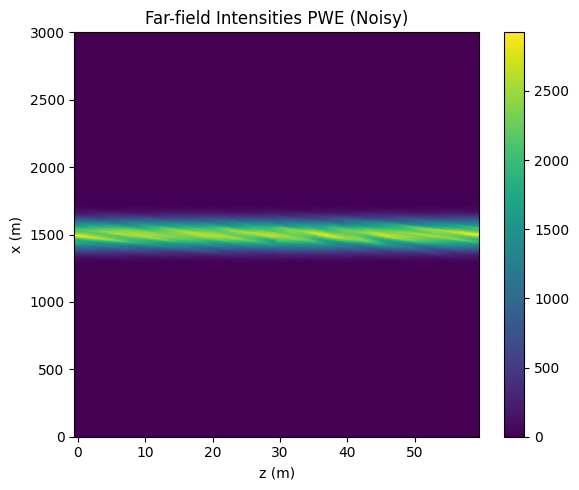

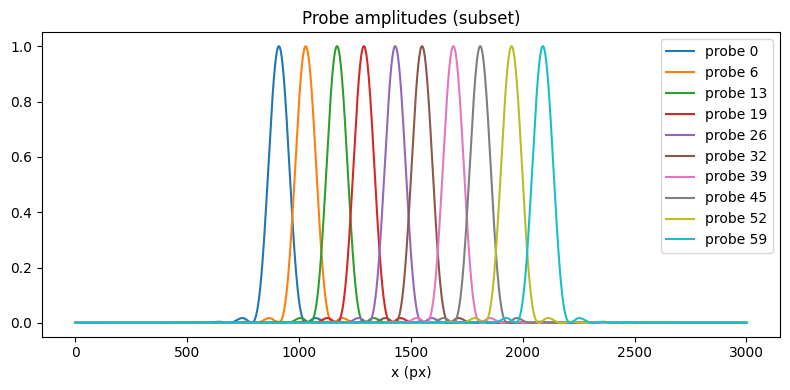

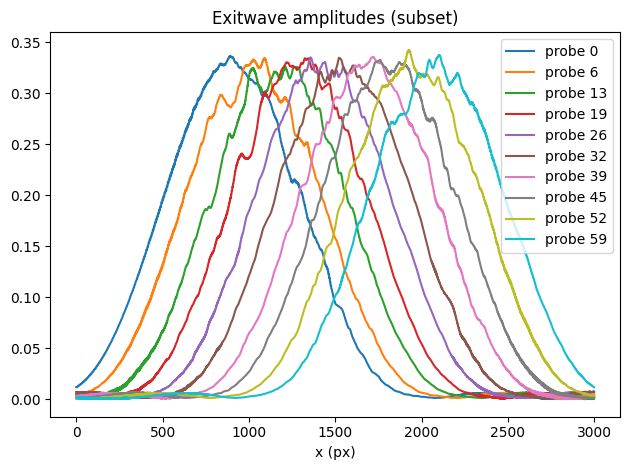

In [11]:
original_shape = exit_waves.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data_ew = zoom(exit_waves, zoom_factors, order=1)
data = np.abs(np.fft.fft(data_ew)) ** 2

print(f"Original exit waves shape: {exit_waves.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

2025-12-12 15:18:19,103 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-12 15:18:33,645 - INFO - [Iter 001] Mean Loss = 0.123588, Time = 14.53 seconds
2025-12-12 15:18:55,381 - INFO - [Iter 002] Mean Loss = 0.116293, Time = 21.73 seconds
2025-12-12 15:19:12,886 - INFO - [Iter 003] Mean Loss = 0.113744, Time = 17.50 seconds
2025-12-12 15:19:35,880 - INFO - [Iter 004] Mean Loss = 0.112393, Time = 22.99 seconds
2025-12-12 15:19:59,164 - INFO - [Iter 005] Mean Loss = 0.111546, Time = 23.28 seconds
2025-12-12 15:20:16,576 - INFO - [Iter 006] Mean Loss = 0.110960, Time = 17.41 seconds
2025-12-12 15:20:36,253 - INFO - [Iter 007] Mean Loss = 0.110530, Time = 19.68 seconds
2025-12-12 15:20:53,388 - INFO - [Iter 008] Mean Loss = 0.110200, Time = 17.13 seconds
2025-12-12 15:21:12,007 - INFO - [Iter 009] Mean Loss = 0.109939, Time = 18.62 seconds
2025-12-12 15:21:28,121 - INFO - [Iter 010] Mean Loss = 0.109726, Time = 16.11 seconds


Reconstruction time: 189.02 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

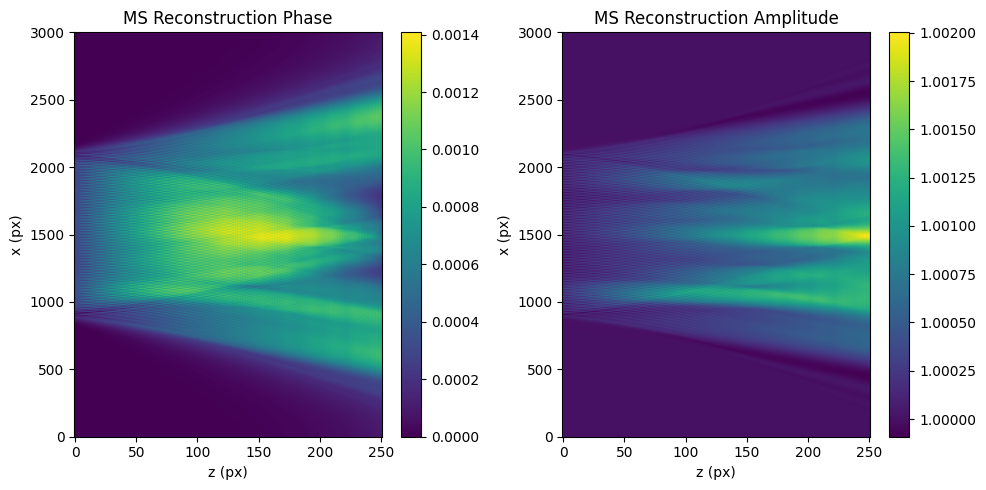

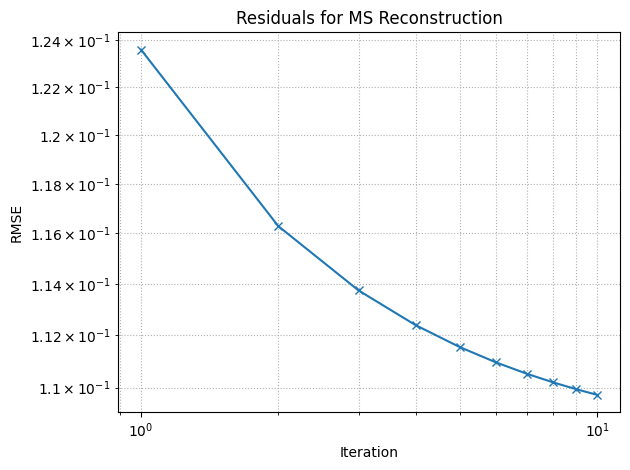

In [5]:
recon_ms = ReconstructorMS(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

2025-12-12 15:21:29,291 - INFO - Initializing Least Squares Solver...
2025-12-12 15:21:29,363 - INFO - Iteration 1/10
2025-12-12 15:21:34,086 - INFO -     RMSE: 0.05727968102705639
2025-12-12 15:21:46,198 - INFO -     Iteration 1 took 16.84 seconds.
2025-12-12 15:21:46,204 - INFO - Iteration 2/10
2025-12-12 15:21:51,006 - INFO -     RMSE: 0.05645508057856209
2025-12-12 15:22:00,603 - INFO -     Iteration 2 took 14.40 seconds.
2025-12-12 15:22:00,614 - INFO - Iteration 3/10
2025-12-12 15:22:05,218 - INFO -     RMSE: 0.05573985399731019
2025-12-12 15:22:19,339 - INFO -     Iteration 3 took 18.72 seconds.
2025-12-12 15:22:19,345 - INFO - Iteration 4/10
2025-12-12 15:22:24,431 - INFO -     RMSE: 0.0551025825862731
2025-12-12 15:22:36,510 - INFO -     Iteration 4 took 17.16 seconds.
2025-12-12 15:22:36,518 - INFO - Iteration 5/10
2025-12-12 15:22:42,020 - INFO -     RMSE: 0.05453407638063199
2025-12-12 15:22:56,068 - INFO -     Iteration 5 took 19.55 seconds.
2025-12-12 15:22:56,069 - INFO 

Reconstruction time: 174.10 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

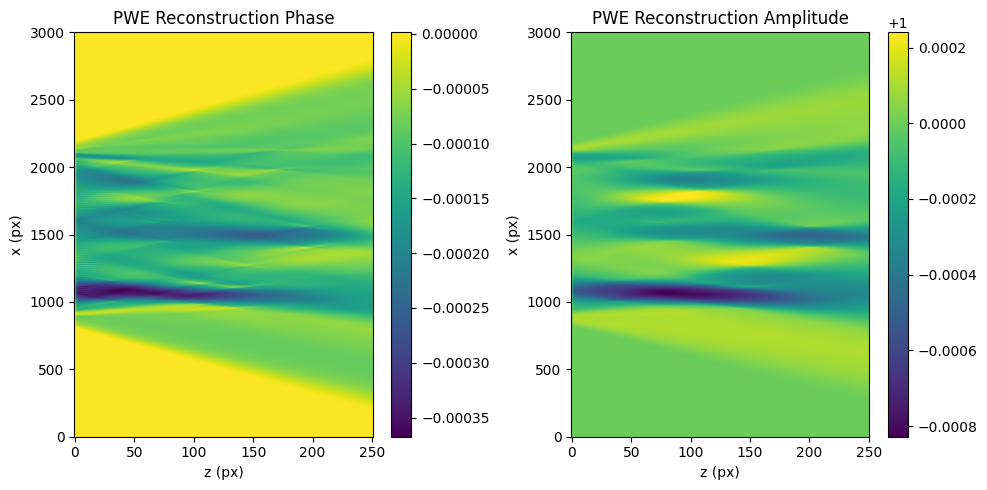

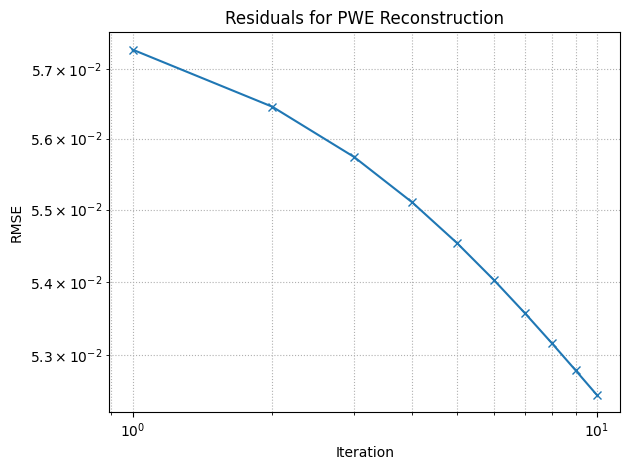

In [6]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

## Phase Retrieval

2025-12-12 15:24:24,423 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-12 15:24:43,547 - INFO - [Iter 001] Mean Loss = 0.005898, Time = 19.12 seconds
2025-12-12 15:25:00,169 - INFO - [Iter 002] Mean Loss = 0.005267, Time = 16.62 seconds
2025-12-12 15:25:18,327 - INFO - [Iter 003] Mean Loss = 0.005022, Time = 18.15 seconds
2025-12-12 15:25:34,761 - INFO - [Iter 004] Mean Loss = 0.004894, Time = 16.43 seconds
2025-12-12 15:25:57,323 - INFO - [Iter 005] Mean Loss = 0.004819, Time = 22.56 seconds
2025-12-12 15:26:14,390 - INFO - [Iter 006] Mean Loss = 0.004772, Time = 17.07 seconds
2025-12-12 15:26:32,665 - INFO - [Iter 007] Mean Loss = 0.004742, Time = 18.27 seconds
2025-12-12 15:26:50,538 - INFO - [Iter 008] Mean Loss = 0.004722, Time = 17.87 seconds
2025-12-12 15:27:12,719 - INFO - [Iter 009] Mean Loss = 0.004710, Time = 22.18 seconds
2025-12-12 15:27:27,409 - INFO - [Iter 010] Mean Loss = 0.004702, Time = 14.69 seconds


Reconstruction time: 182.99 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

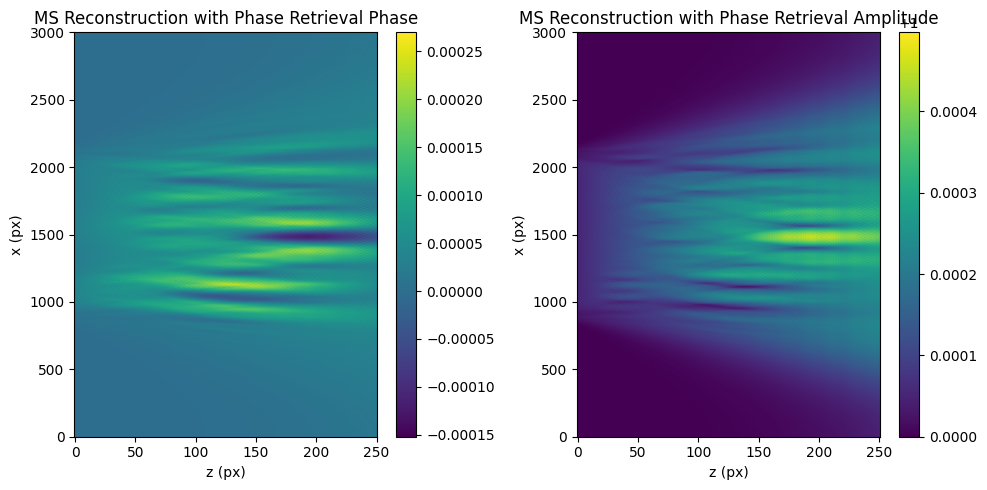

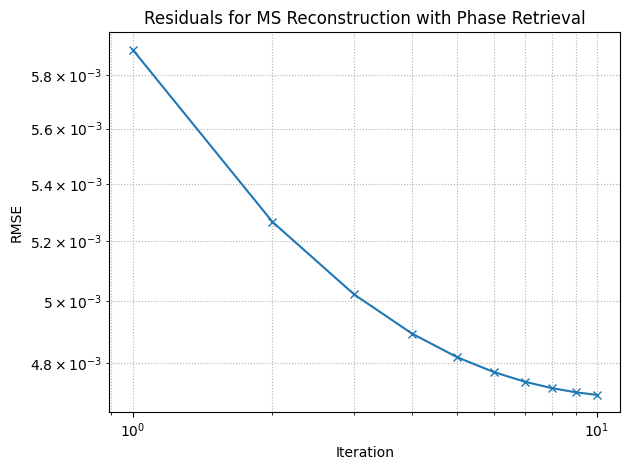

In [7]:
recon_ms = ReconstructorMS(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval",
)

2025-12-12 15:27:28,222 - INFO - Initializing Least Squares Solver...
2025-12-12 15:27:28,284 - INFO - Iteration 1/10
2025-12-12 15:27:35,274 - INFO -     RMSE: 0.006333354337925592
2025-12-12 15:27:46,518 - INFO -     Iteration 1 took 18.23 seconds.
2025-12-12 15:27:46,523 - INFO - Iteration 2/10
2025-12-12 15:27:51,104 - INFO -     RMSE: 0.006131470526091655
2025-12-12 15:28:01,871 - INFO -     Iteration 2 took 15.35 seconds.
2025-12-12 15:28:01,872 - INFO - Iteration 3/10
2025-12-12 15:28:06,896 - INFO -     RMSE: 0.005943603723778652
2025-12-12 15:28:19,174 - INFO -     Iteration 3 took 17.30 seconds.
2025-12-12 15:28:19,175 - INFO - Iteration 4/10
2025-12-12 15:28:24,130 - INFO -     RMSE: 0.005766074403304238
2025-12-12 15:28:35,595 - INFO -     Iteration 4 took 16.42 seconds.
2025-12-12 15:28:35,596 - INFO - Iteration 5/10
2025-12-12 15:28:41,279 - INFO -     RMSE: 0.005598059498231282
2025-12-12 15:28:53,510 - INFO -     Iteration 5 took 17.91 seconds.
2025-12-12 15:28:53,518 -

Reconstruction time: 161.85 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

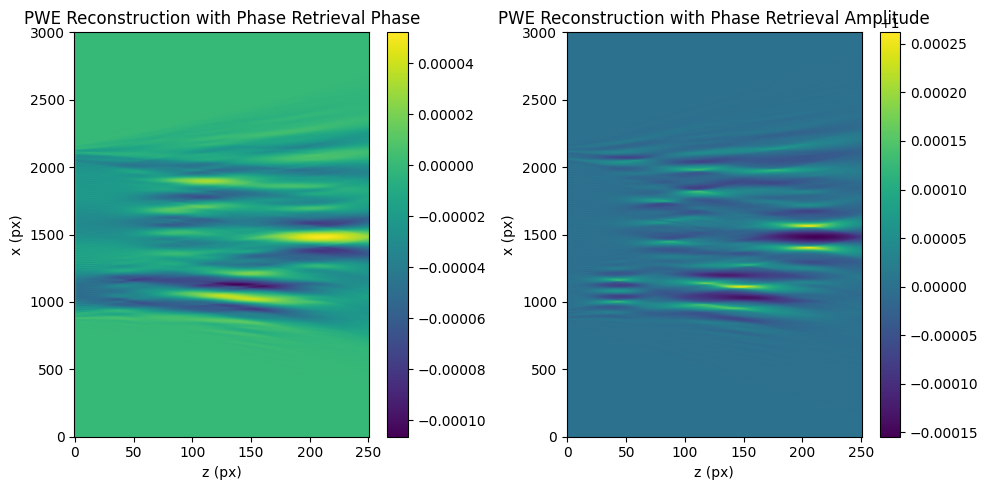

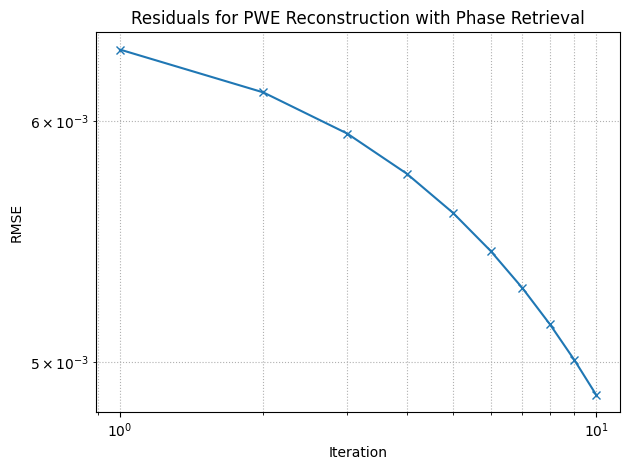

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval",
)

# Phase Retrieval (noisy data)

In [9]:
rng = np.random.default_rng(seed=42)
data_noisy = data.copy() + rng.poisson(np.abs(data))

2025-12-12 15:30:11,111 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-12 15:30:25,087 - INFO - [Iter 001] Mean Loss = 0.052535, Time = 13.97 seconds
2025-12-12 15:30:40,925 - INFO - [Iter 002] Mean Loss = 0.033841, Time = 15.84 seconds
2025-12-12 15:30:54,960 - INFO - [Iter 003] Mean Loss = 0.024953, Time = 14.03 seconds
2025-12-12 15:31:13,609 - INFO - [Iter 004] Mean Loss = 0.020712, Time = 18.65 seconds
2025-12-12 15:31:26,715 - INFO - [Iter 005] Mean Loss = 0.019384, Time = 13.10 seconds
2025-12-12 15:31:42,216 - INFO - [Iter 006] Mean Loss = 0.019801, Time = 15.50 seconds
2025-12-12 15:31:56,236 - INFO - [Iter 007] Mean Loss = 0.021110, Time = 14.02 seconds
2025-12-12 15:32:09,419 - INFO - [Iter 008] Mean Loss = 0.022797, Time = 13.18 seconds
2025-12-12 15:32:25,156 - INFO - [Iter 009] Mean Loss = 0.024598, Time = 15.73 seconds
2025-12-12 15:32:37,768 - INFO - [Iter 010] Mean Loss = 0.026387, Time = 12.61 seconds


Reconstruction time: 146.65 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)'}, xlabel='Iteration', ylabel='RMSE'>)

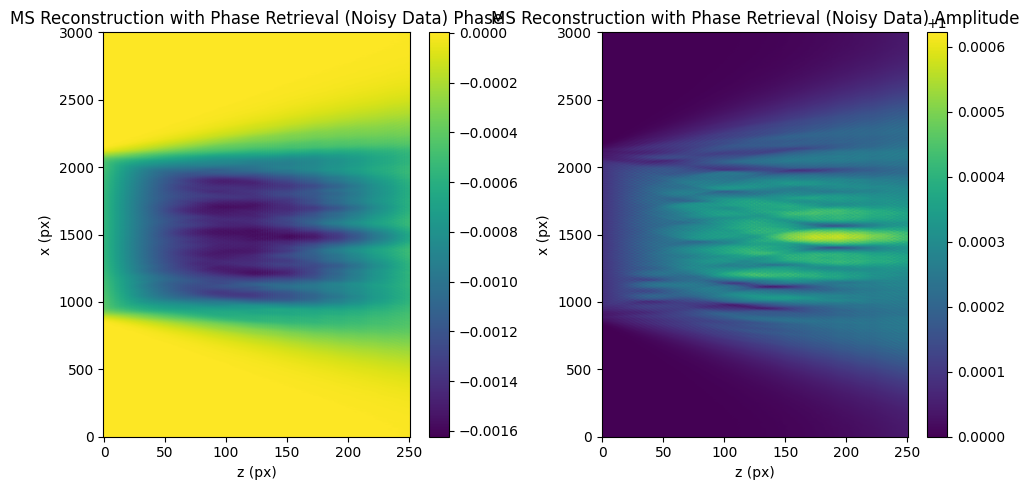

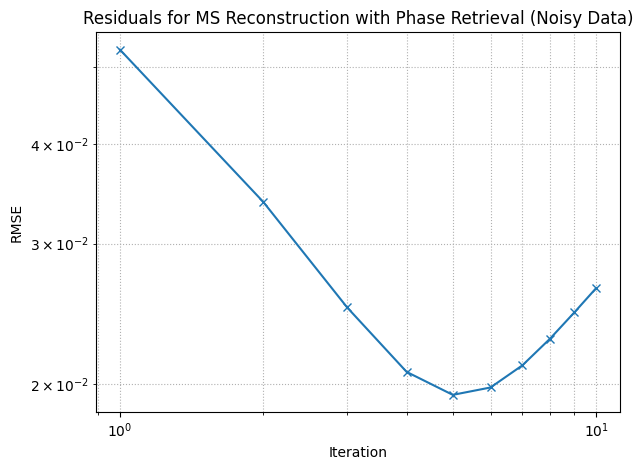

In [10]:
recon_ms = ReconstructorMS(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)",
)

2025-12-12 15:32:38,677 - INFO - Initializing Least Squares Solver...
2025-12-12 15:32:38,746 - INFO - Iteration 1/10
2025-12-12 15:32:41,888 - INFO -     RMSE: 0.06318148272094345
2025-12-12 15:32:54,441 - INFO -     Iteration 1 took 15.70 seconds.
2025-12-12 15:32:54,442 - INFO - Iteration 2/10
2025-12-12 15:32:58,293 - INFO -     RMSE: 0.059117158055519384
2025-12-12 15:33:06,848 - INFO -     Iteration 2 took 12.41 seconds.
2025-12-12 15:33:06,849 - INFO - Iteration 3/10
2025-12-12 15:33:10,631 - INFO -     RMSE: 0.055364439165963286
2025-12-12 15:33:19,693 - INFO -     Iteration 3 took 12.84 seconds.
2025-12-12 15:33:19,694 - INFO - Iteration 4/10
2025-12-12 15:33:23,744 - INFO -     RMSE: 0.05188379600831274
2025-12-12 15:33:37,057 - INFO -     Iteration 4 took 17.36 seconds.
2025-12-12 15:33:37,058 - INFO - Iteration 5/10
2025-12-12 15:33:41,519 - INFO -     RMSE: 0.048654028482103436
2025-12-12 15:33:50,709 - INFO -     Iteration 5 took 13.65 seconds.
2025-12-12 15:33:50,716 - I

Reconstruction time: 141.15 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction with Phase Retrieval (Noisy Data)'}, xlabel='Iteration', ylabel='RMSE'>)

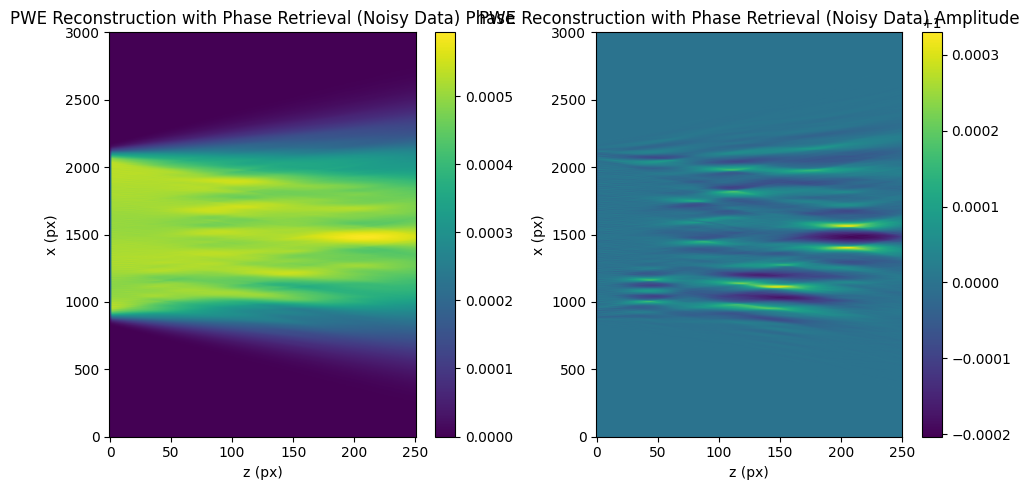

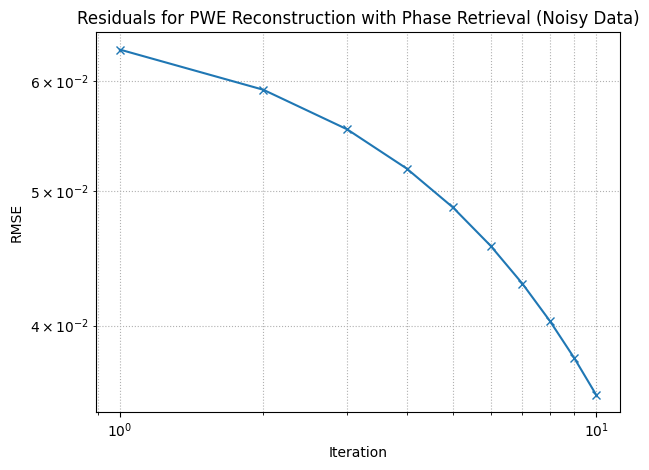

In [11]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval (Noisy Data)",
)